<h1>Required modules :</h1>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import xgboost as xgb
%matplotlib inline 


<h1>Read the file :</h1>

In [ ]:
df = pd.read_csv("home_value.csv")

<h1>Converting data into numbers and removing empty spaces and optimizing the address:</h1>

In [ ]:
df["Area"] = pd.to_numeric(df["Area"], errors="coerce")
df["Parking"] = df["Parking"].astype(int)
df["Warehouse"] = df["Warehouse"].astype(int)
df["Elevator"] = df["Elevator"].astype(int)
df["Room"] = df["Room"].astype(int)
df["Price"] = df["Price"].replace({',': ''}, regex=True).astype(float)

df.dropna(subset=["Area", "Room", "Parking", "Price"], inplace=True)
df = df[df["Address"].notna()]

df["Address_encoded"] = df.groupby("Address")["Price"].transform("mean")
df.drop("Address", axis=1, inplace=True)

<h1>Remove outliers in price:</h1>

In [ ]:
q1, q3 = df["Price"].quantile([0.05, 0.95])
df = df[(df["Price"] >= q1) & (df["Price"] <= q3)]


<h1>Price per square meter</h1>

In [ ]:
df["Price_per_Area"] = df["Price"] / df["Area"]

## Logarithmic transformation :
**Avoid data fragmentation**

In [ ]:
df["Log_Price"] = np.log1p(df["Price"])

<h1>Assign values ​​to x and y : </h1>

In [ ]:
features = ["Area", "Room", "Address_encoded", "Parking", "Elevator", "Warehouse","Price_per_Area"]
X = df[features]
y = df["Log_Price"].values

<h1>Divide the data into test and train : </h1>
<font color="#afeeee">20% is assigned to the test and 80% to the train</font>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=70)

<h1>Scale Features :</h1>

In [ ]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<h1>XGBoost Model :</h1>

In [ ]:
best_params = {
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 5,
    'min_child_weight': 5,
    'subsample': 0.7,
    'colsample_bytree': 1.0,
    'alpha': 0,
    'lambda': 0,
    'random_state': 150
}
model = xgb.XGBRegressor(**best_params)


<h1>Train the model :</h1>

In [ ]:
model.fit(X_train, y_train)

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None, ...)

<h1>Predictions :</h1>

In [ ]:
y_train_pred = np.expm1(model.predict(X_train))
y_test_pred = np.expm1(model.predict(X_test))


<h1>Model Evaluation: </h1>

In [ ]:
r2_train = r2_score(np.expm1(y_train), y_train_pred)
r2_test = r2_score(np.expm1(y_test), y_test_pred)
mae_train = mean_absolute_error(np.expm1(y_train), y_train_pred)
mae_test = mean_absolute_error(np.expm1(y_test), y_test_pred)
mse_train = mean_squared_error(np.expm1(y_train), y_train_pred)
mse_test = mean_squared_error(np.expm1(y_test), y_test_pred)


<h1>Cross-validation MAE:</h1>

In [ ]:
cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
cv_mae = -cv_scores.mean()


<h1>Print results : </h1>

In [ ]:
print(f"Train R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Train MAE: {mae_train:,.2f}")
print(f"Test MAE: {mae_test:,.2f}")
print(f"Cross-Validation MAE: {cv_mae:.2f}")

Train R²: 0.9989
Test R²: 0.9972
Train MAE: 63,995,082.34
Test MAE: 84,312,767.95
Cross-Validation MAE: 0.02


<h1>Residual Distribution Plot : </h1>

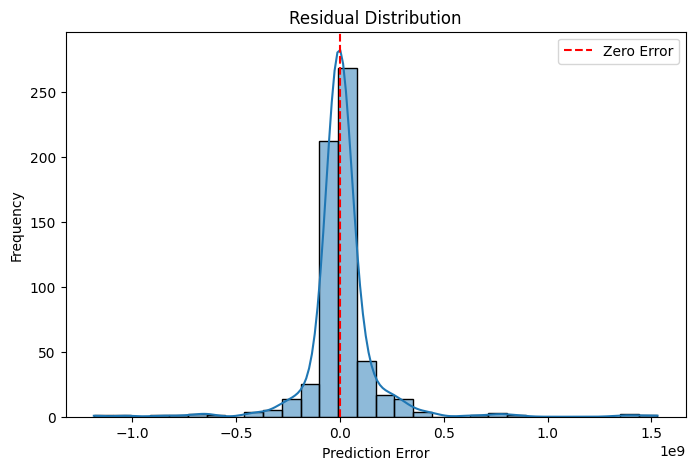

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot((np.expm1(y_test) - y_test_pred), bins=30, kde=True)
plt.axvline(0, color='red', linestyle='dashed', label="Zero Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.legend()
plt.show()

<h1>Predicting Prices for New Data : </h1>

In [ ]:
new_data = pd.DataFrame({
    "Area": [120, 180, 250],
    "Room": [2, 3, 4],
    "Address_encoded": [25000000000, 30000000000, 20000000000],
    "Parking": [1, 0, 1],
    "Elevator": [1, 1, 0],
    "Warehouse": [0, 1, 1],
    "Price_per_Area": [50000000, 45000000, 40000000]
})
new_data_scaled = scaler.transform(new_data)
predicted_log_prices = model.predict(new_data_scaled)
predicted_prices = np.expm1(predicted_log_prices)

new_data["Predicted_Price"] = predicted_prices
print(new_data[["Area", "Room", "Predicted_Price"]])


   Area  Room  Predicted_Price
0   120     2     6.017321e+09
1   180     3     8.424470e+09
2   250     4     9.649550e+09


<h1>Final Model Evaluation (Train/Test Errors) : </h1>

In [ ]:
train_r2 = r2_score(np.expm1(y_train), y_train_pred)
test_r2 = r2_score(np.expm1(y_test), y_test_pred)
mae = mean_absolute_error(np.expm1(y_test), y_test_pred)
r2 = r2_score(np.expm1(y_test), y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)


print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.2f}")


Train R²: 0.9989
Test R²: 0.9972
MAE: 84312767.95
R² Score: 0.9972
MSE: 26443364749467389952.00


<h1>True vs Predicted Plot : </h1>

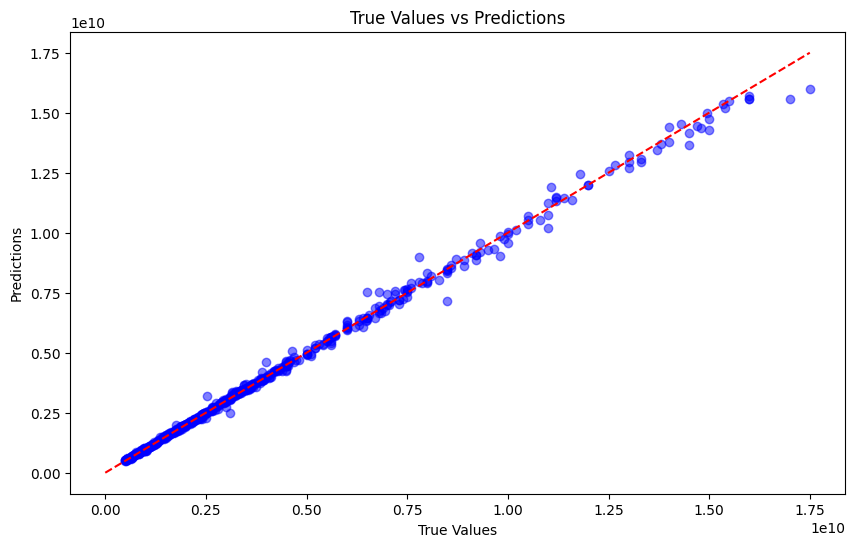

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), y_test_pred, color='blue', alpha=0.5)
plt.plot([0, np.max(np.expm1(y_test))], [0, np.max(np.expm1(y_test))], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs Predictions")
plt.show()

<h1>Prediction Error Distribution : </h1>

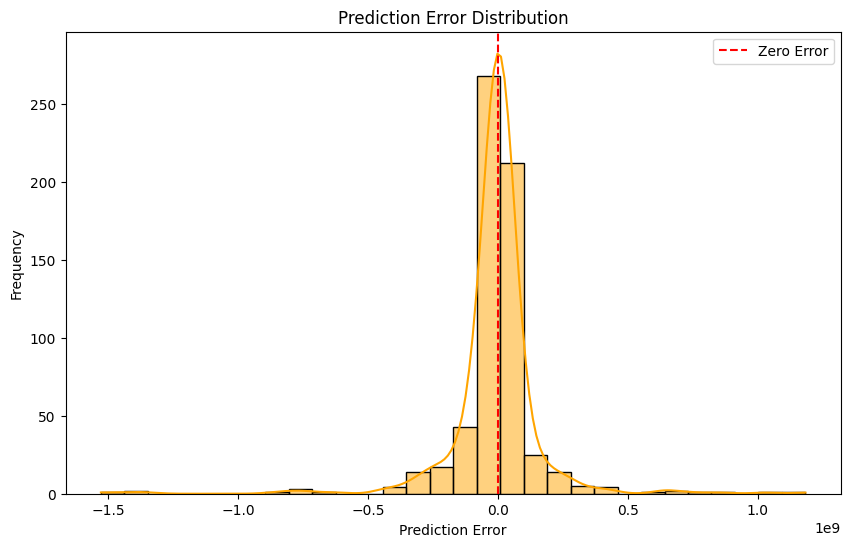

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test_pred - np.expm1(y_test), bins=30, kde=True, color='orange')
plt.axvline(0, color='red', linestyle='dashed', label="Zero Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")
plt.legend()
plt.show()


<h1>True vs Predicted Scatter Plot : </h1>

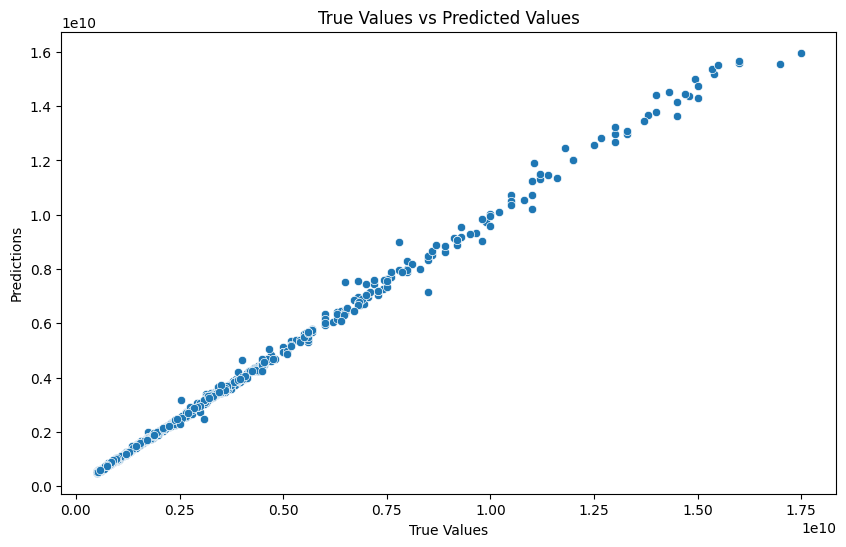

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.expm1(y_test), y=y_test_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs Predicted Values")
plt.show()